# Source finding demo

## Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
#from astropy.table import QTable
from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

## Read data

Please *choose one* of the following:

### images:

In [2]:
hdu = fits.open('data/hcg44_cube_R.fits')
data = hdu[0].data[69]*1.
data = hdu[0].data[:, 270, :]*1.
data = hdu[0].data[:, 170, :]*1.
data = hdu[0].data[99]*1.

In [3]:
hdu = fits.open('data/CIG_335.fits')
data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

### results:

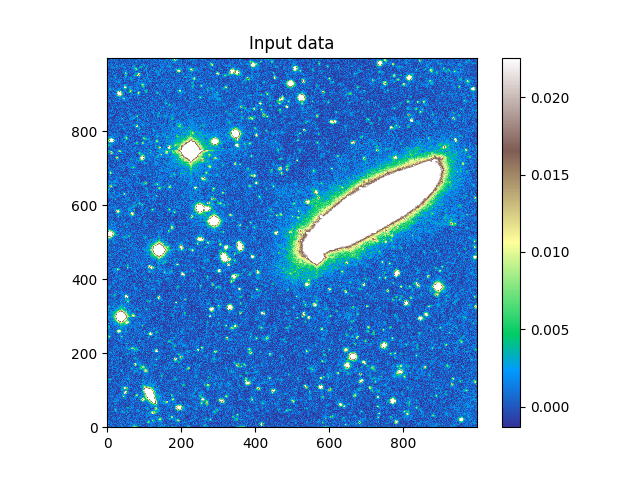

In [4]:
# fig, ax = fm.select('data', nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 3))
#fig, ax = fm.select('data')
plt.close('data')
fig = plt.figure('data')
ax = fig.subplots()

im = ax.imshow(data,
               interpolation='nearest', origin='lower', cmap='terrain',
               vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
              )
ax.set_title('Input data')
cb = fig.colorbar(im, ax=ax)

## Find threshold

### cumulative mass:

In [5]:
sorted_by_data = np.argsort(data.flatten())
sorted_data = data.flatten()[sorted_by_data]

Allow for statistical weights:

In [6]:
weights = np.ones_like(data)
sorted_weight = weights.flatten()[sorted_by_data]

In [7]:
cumulative_mass = np.nancumsum(sorted_weight)
sorted_weight /= cumulative_mass[-1]
cumulative_mass /= cumulative_mass[-1]

### density peak (mode of the probability distribution):
Here we have a couple of free parameters:

In [8]:
delta = .5  # relative size of the smoothing kernel (delta <= 1)

# mass fractions to be tested:
m = np.linspace(delta**2,  # somewhat arbitrary :^(
                1/(1+delta),  # do not overshoot
                int(np.sqrt(data.size)) # a reasonable number of trials
               )

Find maximum:

In [9]:
x_top = np.interp((1+delta)*m, cumulative_mass, sorted_data)
x_mid = np.interp(m, cumulative_mass, sorted_data)
x_bot = np.interp((1-delta)*m, cumulative_mass, sorted_data)
rho_top = delta * m / (x_top - x_mid)
rho_bot = delta * m / (x_mid - x_bot)
peak = np.nanargmin((rho_top - rho_bot) ** 2)
data_mode = x_mid[peak]

m_background = 2 * m[peak]
m_signal = 1 - m_background
threshold_guess = np.interp(m_background, cumulative_mass, sorted_data)

### purity:

In [10]:
m_above = 1 - cumulative_mass
m_symmetric_above = np.interp(2 * data_mode - sorted_data, sorted_data, cumulative_mass, left=0.)
left = np.where(sorted_data < data_mode)
m_symmetric_above[left] = m_background - cumulative_mass[left]
m_signal_above = m_above - m_symmetric_above
purity = m_signal_above / (m_above+1e-30)
purity[-1] = 1

### results:

In [11]:
print(f'data_mode = {data_mode}')
print(f'threshold_guess = {threshold_guess}, m_signal = {m_signal}')

data_mode = 0.0004482927539949746
threshold_guess = 0.0026369258242411905, m_signal = 0.1855188521855189


Text(0.5, 1.0, 'delta = 0.5')

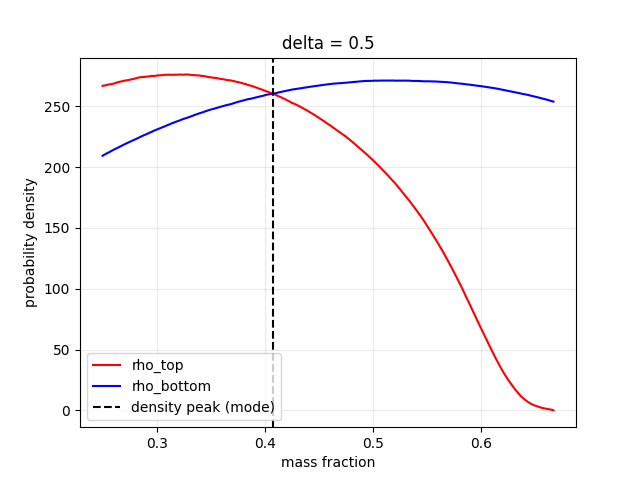

In [12]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots()

ax.plot(m, rho_top, 'r-', label='rho_top')
ax.plot(m, rho_bot, 'b-', label='rho_bottom')
ax.axvline(m[peak], c='k', ls='--', label='density peak (mode)')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('mass fraction')
ax.set_ylabel('probability density')
ax.set_title(f'delta = {delta}')

(-0.0050287372432649136, 0.011402352748514751)

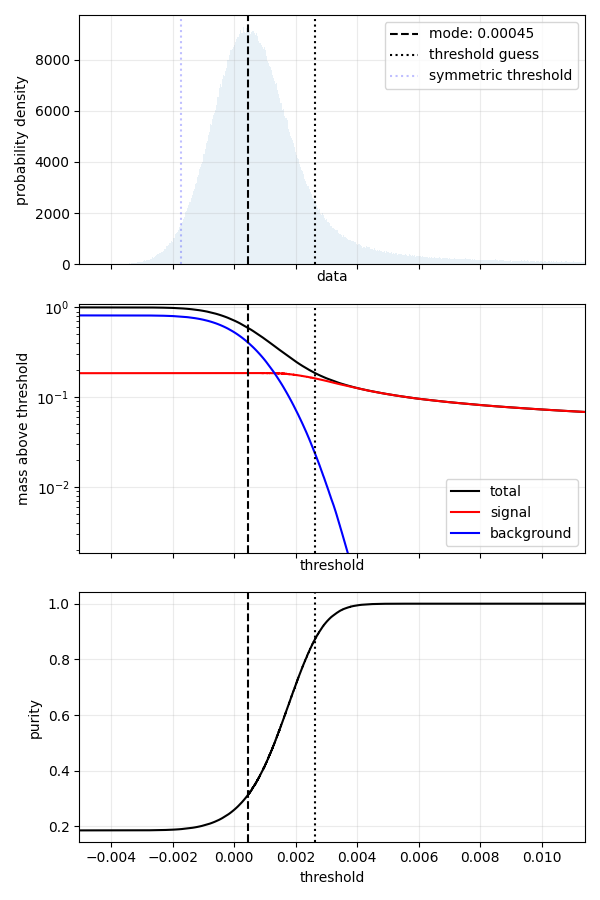

In [13]:
L = max(data_mode-sorted_data[0], threshold_guess-data_mode)

plt.close('statistics')
fig = plt.figure('statistics', figsize=(6, 9))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=3, sharex=True)

# density:

ax[0].hist(sorted_data, bins=np.linspace(sorted_data[0], data_mode + 5*L, int(np.sqrt(data.size))), alpha=.1)
ax[0].axvline(data_mode, c='k', ls='--', label=f'mode: {data_mode:.2g}')
ax[0].axvline(threshold_guess, c='k', ls=':', label='threshold guess')
ax[0].axvline(2*data_mode-threshold_guess, c='b', ls=':', alpha=.25, label='symmetric threshold')

ax[0].grid(alpha=.25)
ax[0].legend()
ax[0].set_xlabel('data')
ax[0].set_ylabel('probability density')

# mass:

ax[1].plot(sorted_data, m_above, 'k-', label='total')
ax[1].plot(sorted_data, m_signal_above, 'r-', label='signal')
ax[1].plot(sorted_data, m_symmetric_above, 'b-', label='background')
ax[1].axvline(data_mode, c='k', ls='--')
ax[1].axvline(threshold_guess, c='k', ls=':')

ax[1].grid(alpha=.25)
ax[1].legend(loc='lower right')
ax[1].set_xlabel('threshold')
#ax[1].set_xlim(sorted_data[0], data_mode + 5*L)
ax[1].set_ylabel('mass above threshold')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2*m_signal, 1.1)

# purity:

ax[2].plot(sorted_data, purity, 'k-')
ax[2].axvline(data_mode, c='k', ls='--')
ax[2].axvline(threshold_guess, c='k', ls=':')

ax[2].grid(alpha=.25)
#ax[2].legend()
ax[2].set_xlabel('threshold')
ax[2].set_ylabel('purity')

ax[0].set_xlim(sorted_data[0], data_mode + 2*L)

## Hierarchical Overdensity Tree (HOT)

### routine definition:

In [14]:
@njit
def hot(data, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    flat_data = data.flatten()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    max_value = np.zeros_like(flat_data)
    saddle_value = np.full_like(max_value, threshold)
    saddle_area = np.zeros(data.size, dtype=np.int64)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent
                saddle_value[p] = pixel_value
                saddle_area[p] = area[p]+1
            saddle_area[selected_parent] -= 1

        label[pixel] = selected_parent
        area[selected_parent] += 1
        saddle_area[selected_parent] += 1
        saddle_value[selected_parent] = pixel_value
    
    print(f'{n_labels} overdensities found',
          f'{np.count_nonzero(parent[:n_labels+1] == np.arange(n_labels+1)) -1} independent regions')
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               saddle_value[:n_labels+1],
               saddle_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### normal and inverted catalogues:

In [15]:
label, catalog = hot(data-data_mode, 0)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
saddle_value = catalog[3]
saddle_area = catalog[4]

label_inv, catalog_inv = hot(data_mode-data, 0)
segmentation_inv = segm.SegmentationImage(label_inv)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
saddle_value_inv = catalog_inv[3]
saddle_area_inv = catalog_inv[4]


152109 overdensities found 43525 independent regions
135667 overdensities found 38478 independent regions


### selection criterion:

9122 overdensities pass the selection thresholds
[  3   3   3 ... 129   1   1]


/tmp/ipykernel_29997/3056575449.py:26: RuntimeWarning: divide by zero encountered in log
  x = np.log(saddle_area)
/tmp/ipykernel_29997/3056575449.py:27: RuntimeWarning: divide by zero encountered in log
  y = np.log(max_value)


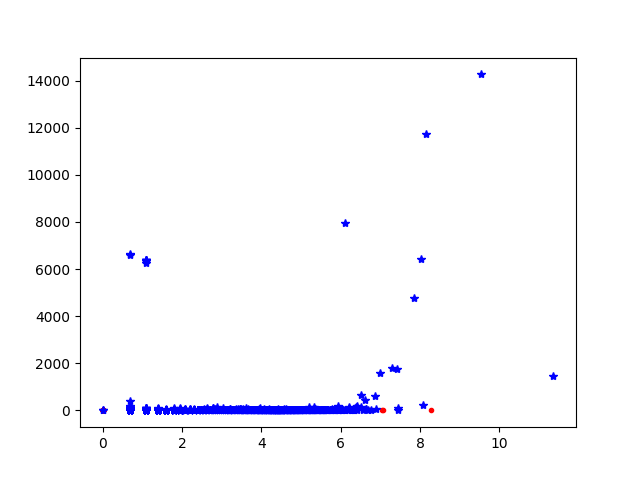

In [16]:
def upper_hull(x, y):
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]

plt.close('test')
fig = plt.figure('test')
ax = fig.subplots()

#x = np.random.normal(size=300)*np.pi
#y = np.random.normal(size=x.size) * np.sin(x)
x_inv = np.log(saddle_area_inv[1:])
y_inv = np.log(max_value_inv[1:])
xx, yy = upper_hull(x_inv, y_inv)

cut_inv = np.interp(x_inv, xx, yy)
ax.plot(x_inv, np.exp(y_inv-cut_inv), 'r.')

x = np.log(saddle_area)
y = np.log(max_value)
cut = np.interp(x, xx, yy)
#ax.plot(x, y-cut, 'c.', alpha=.2)
selected = np.where(y > cut)
print(f'{selected[0].size} overdensities pass the selection thresholds')
ax.plot(x[selected], np.exp(y[selected]-cut[selected]), 'b*')

#ax.set_ylim(0, 2)
print(saddle_area[selected])

0.6950000000000001


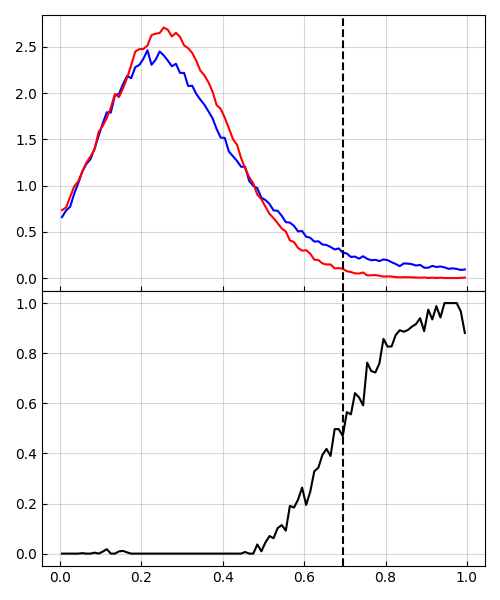

In [17]:
plt.close('cut-based')
fig = plt.figure('cut-based', figsize=(5, 6))
ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

hist_inv, bins_inv = np.histogram(np.exp(y_inv-cut_inv), bins=np.linspace(0, 1, 101), density=True)
hist, bins = np.histogram(np.exp(y-cut), bins=np.linspace(0, 1, 101), density=True)
x_mid = (bins[1:] + bins[:-1]) / 2
cut_threshold = np.max(x_mid[hist < 3*hist_inv])
print(cut_threshold)

ax[0, 0].plot(x_mid, hist, 'b-')
ax[0, 0].plot(x_mid, hist_inv, 'r-')
ax[0, 0].axvline(cut_threshold, c='k', ls='--')

ax[1, 0].plot(x_mid, np.clip(hist-hist_inv, 0, np.inf)/(hist+hist_inv), 'k-')
ax[1, 0].axvline(cut_threshold, c='k', ls='--')


In [18]:
x = np.log(saddle_area)
y = np.log(max_value)
x_inv = np.log(saddle_area_inv[1:])
y_inv = np.log(max_value_inv[1:])

xx, yy = upper_hull(x_inv, y_inv)
cut = np.interp(x, xx, yy)
cut_inv = np.interp(x_inv, xx, yy)

cut_bins = np.linspace(0, 1, 101)
hist_inv, cut_bins = np.histogram(np.exp(y_inv-cut_inv), bins=cut_bins, density=True)
hist, cut_bins = np.histogram(np.exp(y-cut), bins=cut_bins, density=True)
cut_mid = (cut_bins[1:] + cut_bins[:-1]) / 2
cut_threshold = np.max(cut_mid[hist < 3*hist_inv])
print(f'select objects above {100*cut_threshold:.1f}% of upper hull')

selected = np.where(y > np.log(cut_threshold) + cut)
print(f'{selected[0].size} overdensities pass the selection threshold')
print(saddle_area[selected])

select objects above 69.5% of upper hull
16087 overdensities pass the selection threshold
[3 3 3 ... 1 1 1]


/tmp/ipykernel_29997/4145442943.py:1: RuntimeWarning: divide by zero encountered in log
  x = np.log(saddle_area)
/tmp/ipykernel_29997/4145442943.py:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(max_value)


In [19]:
valid_labels = -np.arange(parent.size)
valid_labels[selected] = 0
valid_labels += np.arange(parent.size)
valid_labels = valid_labels[label]
final_selection = segm.SegmentationImage(valid_labels)

### results:

In [20]:
'''
plot_areas = [2, 3, 4, 10, 20, 50, 80]

plt.close('selection model')
fig = plt.figure('selection model', figsize=(8, 4+np.sqrt(len(plot_areas))))
ax = fig.subplots(nrows=len(plot_areas), ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)


for i, n in enumerate(plot_areas):
    ax[i, 0].set_ylabel('fraction above value')
    ax[i, 0].set_yscale('log')

    selected_regions = np.where(saddle_area == n)
    seleced_max = np.sort(max_value[selected_regions])
    seleced_saddle = np.sort(saddle_value[selected_regions])
    selected_regions_inv = np.where(saddle_area_inv == n)
    seleced_max_inv = np.sort(max_value_inv[selected_regions_inv])
    seleced_saddle_inv = np.sort(saddle_value_inv[selected_regions_inv])

    f = np.arange(seleced_max.size)[::-1]/seleced_max.size
    ax[i, 0].plot(seleced_max, f, 'b-', label='positive')
    f = np.arange(seleced_max_inv.size)[::-1]/seleced_max_inv.size
    ax[i, 0].plot(seleced_max_inv, f, 'r-', label='negative')
    ax[i, 0].plot(x_bg, 1-P_bg**n, 'k-', label=f'saddle area={n}')

    f = np.arange(seleced_saddle.size)[::-1]/seleced_saddle.size
    ax[i, 1].plot(seleced_saddle, f, 'b-', label='positive')
    f = np.arange(seleced_saddle_inv.size)[::-1]/seleced_saddle_inv.size
    ax[i, 1].plot(seleced_saddle_inv, f, 'r-', label='negative')
    ax[i, 1].plot(x_bg, (1-P_bg)**n, 'k-', label=f'saddle area={n}')

    ax[i, 0].legend(loc='lower left')
    ax[i, 0].set_ylim(1/n_regions, 1)

ax[-1, 0].set_xlabel('max value')
ax[-1, 1].set_xlabel('saddle value')
ax[-1, 0].set_xscale('log')
ax[-1, 0].set_xlim(x_bg[-1]/100, x_bg[-1])
'''

"\nplot_areas = [2, 3, 4, 10, 20, 50, 80]\n\nplt.close('selection model')\nfig = plt.figure('selection model', figsize=(8, 4+np.sqrt(len(plot_areas))))\nax = fig.subplots(nrows=len(plot_areas), ncols=2, squeeze=False,\n                  sharex=True, sharey='row',\n                  gridspec_kw={'hspace': 0, 'wspace': 0})\nfor axis in ax.flatten():\n    axis.tick_params(which='both', direction='in')\n    axis.grid(alpha=.5)\nfig.set_tight_layout(True)\n\n\nfor i, n in enumerate(plot_areas):\n    ax[i, 0].set_ylabel('fraction above value')\n    ax[i, 0].set_yscale('log')\n\n    selected_regions = np.where(saddle_area == n)\n    seleced_max = np.sort(max_value[selected_regions])\n    seleced_saddle = np.sort(saddle_value[selected_regions])\n    selected_regions_inv = np.where(saddle_area_inv == n)\n    seleced_max_inv = np.sort(max_value_inv[selected_regions_inv])\n    seleced_saddle_inv = np.sort(saddle_value_inv[selected_regions_inv])\n\n    f = np.arange(seleced_max.size)[::-1]/seleced

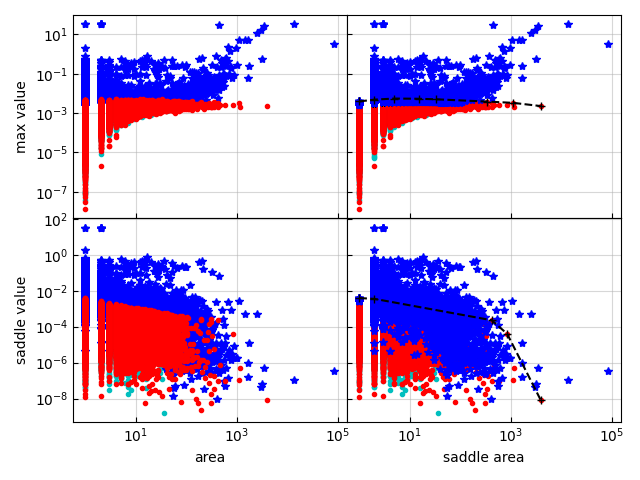

In [21]:
plt.close('selection')
fig = plt.figure('selection')
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[0, 0].set_ylabel('max value')
ax[0, 0].set_yscale('log')
ax[0, 0].plot(catalog[1], catalog[2], 'c.')
ax[0, 0].plot(catalog[1][selected], catalog[2][selected], 'b*')
ax[0, 0].plot(catalog_inv[1], catalog_inv[2], 'r.')

ax[1, 0].set_ylabel('saddle value')
ax[1, 0].set_yscale('log')
ax[1, 0].plot(catalog[1], catalog[3], 'c.')
ax[1, 0].plot(catalog[1][selected], catalog[3][selected], 'b*')
ax[1, 0].plot(catalog_inv[1], catalog_inv[3], 'r.')

ax[-1, 0].set_xlabel('area')
ax[-1, 0].set_xscale('log')


ax[0, 1].plot(catalog[4], catalog[2], 'c.')
ax[0, 1].plot(catalog_inv[4], catalog_inv[2], 'r.')
ax[0, 1].plot(catalog[4][selected], catalog[2][selected], 'b*')
#ax[0, 1].plot(nn, cut_max, 'k-')
#ax[0, 1].axhline(threshold_guess, c='k', ls='--')
x = np.log(catalog_inv[4][1:])
y = np.log(catalog_inv[2][1:])
xx, yy = upper_hull(x, y)
ax[0, 1].plot(np.exp(xx), np.exp(yy), 'k+--')

ax[1, 1].plot(catalog[4], catalog[3], 'c.')
ax[1, 1].plot(catalog_inv[4], catalog_inv[3], 'r.')
ax[1, 1].plot(catalog[4][selected], catalog[3][selected], 'b*')
#ax[1, 1].plot(nn, cut_saddle, 'k--')
x = np.log(catalog_inv[4][1:])
y = np.log(catalog_inv[3][1:])
xx, yy = upper_hull(x, y)
ax[1, 1].plot(np.exp(xx), np.exp(yy), 'k+--')

ax[-1, 1].set_xlabel('saddle area')
ax[-1, 1].set_xscale('log')

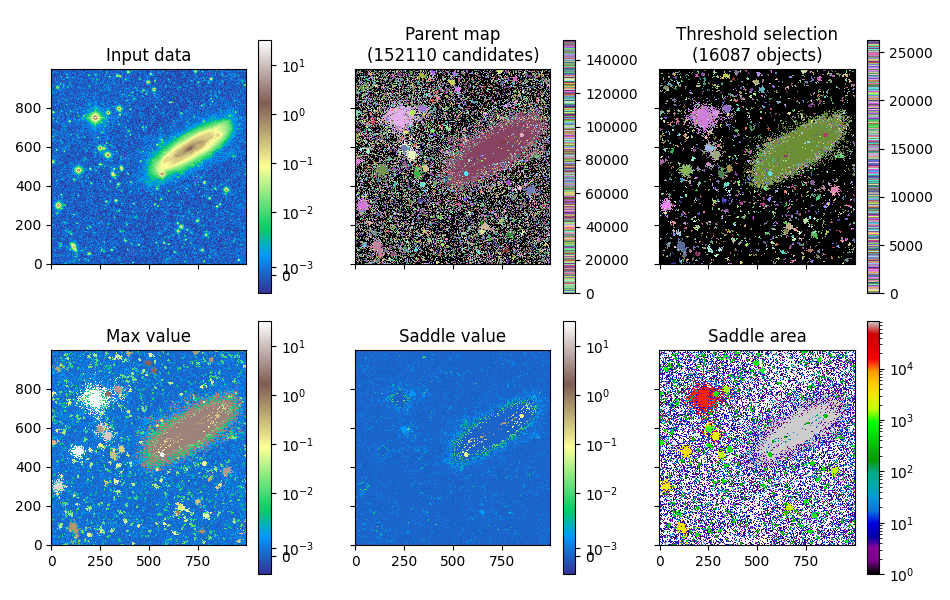

In [24]:
plt.close('HOT')
fig = plt.figure('HOT', figsize=(9.5, 6))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
delta = threshold_guess-data_mode

ax[0, 0].set_title('Input data')
im = ax[0, 0].imshow(
    data-data_mode,
    interpolation='nearest', origin='lower', cmap='terrain',
    norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
    )
cb = fig.colorbar(im, ax=ax[0, 0])

ax[0, 1].set_title(f'Parent map\n({parent.size} candidates)')
im = ax[0, 1].imshow(
    segmentation,
    interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[0, 1])

ax[0, 2].set_title(f'Threshold selection\n({selected[0].size} objects)')
im = ax[0, 2].imshow(
    final_selection,
    interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[0, 2])

ax[1, 0].set_title('Max value')
im = ax[1, 0].imshow(
    max_value[label],
    interpolation='nearest', origin='lower', cmap='terrain',
    norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
    )
cb = fig.colorbar(im, ax=ax[1, 0])

ax[1, 1].set_title('Saddle value')
im = ax[1, 1].imshow(
    saddle_value[label],
    interpolation='nearest', origin='lower', cmap='terrain',
    norm = colors.SymLogNorm(vmin=-delta, linthresh=3*delta, vmax=np.max(data-data_mode)),
    )
cb = fig.colorbar(im, ax=ax[1, 1])

ax[1, 2].set_title('Saddle area')
im = ax[1, 2].imshow(
    saddle_area[label],
    interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
    )
cb = fig.colorbar(im, ax=ax[1, 2])


In [23]:
hdu[0].data.shape

(7000, 7000)